# A set of scaffolds from CheMBL papers

Andrew Dalke has been [working](http://www.dalkescientific.com/writings/diary/archive/2012/08/21/structure_query_collection.html) on putting together a dataset for testing substructure screenout performance for a while now. Due to concerns about privacy and/or confidentiality it's really difficult to get "real world" data on the kinds of things that scientists (really mostly chemists) look for in large-scale research systems like the data warehouses one finds in pharma companies. We have the data, but because of the nature of the searches we can't share it. Andrew visited us recently and the topic of substructure screening came up again. (Aside: There were three people in that room who cared deeply about substructure screening and who have invested some real thought and effort in it, how often does that happen? Sometimes I love my job!) During the conversation we came up with a way to fake having access to our actual queries. This post is about that.

One of the common use cases we see for substructure searching in the warehouse is to find all compounds that are in a particular chemical series. We obviously can't disclose the series that people are searching our database for, but we can fake it by collecting a bunch of substructure queries defining medchem-relevant chemical scaffolds and using those. This would have the added advantage of including things that have query features (variable atom and bond lists). Now we just need a source of medchem relevant scaffolds.

I did a [post](http://rdkit.blogspot.ch/2014/02/more-on-datasets-ii.html) a while ago on the composition of the molecule sets we called "Datasets 2" in the [model fusion](http://pubs.acs.org/doi/abs/10.1021/ci400466r) paper. Since these are pulled from individual publications found in ChEMBL they tend to be made up of a set of molecules from one scaffold and then a few other molecules. One of the things I showed in that post was a method for estimating what the scaffold is in these sets using the RDKit's MCS code. This builds on that.


# On to the work

## Start with the preliminaries

We need to do a bunch of imports and define some functions we'll use later.

*Note:* This is a Python3 notebook, so the code below may not work in Python2.

In [1]:
import numpy
from rdkit.Chem.Draw import IPythonConsole
import pandas as pd
from rdkit.Chem import PandasTools
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import rdFMCS as MCS
import pickle
from rdkit import rdBase
print(rdBase.rdkitVersion)

import time
print(time.asctime())

2015.09.1pre
Thu May 28 04:42:14 2015


In [41]:
# define a function to convert a query molecule to SVG using the new rendering code.

from IPython.display import SVG
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
def moltosvg(mol,molSize=(450,250),kekulize=True):
    mc = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        rdDepictor.Compute2DCoords(mc)
    drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
    # the MolDraw2D code is not very good at the moment at dealing with atom queries,
    # this is a workaround until that's fixed.
    # The rendering is still not going to be perfect because query bonds are not properly indicated
    opts = drawer.drawOptions()
    for atom in mc.GetAtoms():
        if atom.HasQuery() and atom.DescribeQuery().find('AtomAtomicNum')!=0:
            opts.atomLabels[atom.GetIdx()]=atom.GetSmarts()
    drawer.DrawMolecule(mc)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    # It seems that the svg renderer used doesn't quite hit the spec.
    # Here are some fixes to make it work in the notebook, although I think
    # the underlying issue needs to be resolved at the generation step
    return svg.replace('svg:','')

In [43]:
# define a function to find the MCS for a set of molecules and return some summary info about that MCS

import time
# we will use a namedtuple to return the results
from collections import namedtuple
MCSRes=namedtuple('MCSRes',('smarts','numAtoms','numMols','avgNumMolAtoms','mcsTime'))

def MCS_Report(ms,printSmarts=True,
               atomCompare=MCS.AtomCompare.CompareAny,
               bondCompare=MCS.BondCompare.CompareAny,
               completeRingsOnly=True,
               **kwargs):
    t1=time.time()
    mcs = MCS.FindMCS(ms,atomCompare=atomCompare,bondCompare=bondCompare,timeout=30,completeRingsOnly=completeRingsOnly,
                      **kwargs)
    t2=time.time()
    nAts = numpy.array([x.GetNumAtoms() for x in ms])
    print('Mean nAts %.1f, mcs nAts: %d'%(nAts.mean(),mcs.numAtoms))
    if printSmarts: 
        print(mcs.smartsString)
    mcsM = Chem.MolFromSmarts(mcs.smartsString)         
    mcsM.UpdatePropertyCache(False)
    Chem.SetHybridization(mcsM)
    svg = moltosvg(mcsM,kekulize=False)
    tpl = MCSRes(mcs.smartsString,mcs.numAtoms,len(ms),nAts,t2-t1)
    return tpl,svg


## Grab the benchmarking data

In [2]:
import glob
pkls = glob.glob('/home/glandrum/Code/benchmarking_platform/compounds/ChEMBL_II/*.pkl')
print(len(pkls))

37


Get target information from our local ChEMBL copy:

In [3]:
%load_ext sql
%config SqlMagic.feedback = False

In [4]:
import os
tgts={}
for pkl in pkls:
    fn = os.path.split(pkl)[-1]
    basen = os.path.splitext(fn)[0]
    tgtn=int(basen.split('_')[-1])
    data = %sql postgresql://localhost/chembl_20 \
          select tid,pref_name,organism from target_dictionary where tid=:tgtn ;
    tgts[data[0][0]]=(pkl,data[0][1],data[0][2])

In [5]:
for idx in sorted(tgts.keys()):
    pkl,tgt,species = tgts[idx]
    print(idx,tgt,species)

15 Carbonic anhydrase II Homo sapiens
25 Glucocorticoid receptor Homo sapiens
43 Beta-2 adrenergic receptor Homo sapiens
51 Serotonin 1a (5-HT1a) receptor Homo sapiens
61 Muscarinic acetylcholine receptor M1 Homo sapiens
65 Cytochrome P450 19A1 Homo sapiens
72 Dopamine D2 receptor Homo sapiens
87 Cannabinoid CB1 receptor Homo sapiens
90 Dopamine D4 receptor Homo sapiens
93 Acetylcholinesterase Homo sapiens
100 Norepinephrine transporter Homo sapiens
107 Serotonin 2a (5-HT2a) receptor Homo sapiens
108 Serotonin 2c (5-HT2c) receptor Homo sapiens
114 Adenosine A1 receptor Homo sapiens
121 Serotonin transporter Homo sapiens
126 Cyclooxygenase-2 Homo sapiens
130 Dopamine D3 receptor Homo sapiens
165 HERG Homo sapiens
259 Cannabinoid CB2 receptor Homo sapiens
10188 MAP kinase p38 alpha Homo sapiens
10193 Carbonic anhydrase I Homo sapiens
10260 Vanilloid receptor Homo sapiens
10280 Histamine H3 receptor Homo sapiens
10434 Tyrosine-protein kinase SRC Homo sapiens
10980 Vascular endothelial gro

The data is organized in a dictionary with one entry per paper.

The `MCS_Report()` function defined above prints out the mean number of atoms per molecule in the input along with the size of the MCS. This is intended to help assess whether or not the MCS is actually a scaffold.

Mean nAts 29.4, mcs nAts: 26
[#8,#6]-[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1)-[#6]1:[#7,#8]:[#6](-[#6]2:[#6]:[#6]:[#6](:[#6]:[#6]:2)-[#6]-[#7]2-[#6]-[#6](-[#6]-2)-[#6](=[#8])-[#8]):[#7,#8]:[#8,#7]:1


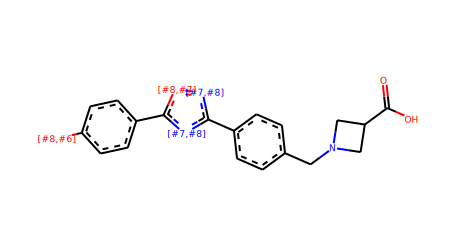

In [40]:
sets = pickle.load(open(tgts[11631][0],'rb'))
docid,cmpds = next(iter(sets.items()))
ids,smis= zip(*cmpds)
mols = [Chem.MolFromSmiles(x) for x in smis]

tpl,svg = MCS_Report(mols,threshold=0.8,completeRingsOnly=True)
SVG(svg)

## Find scaffolds in bulk

Now let's look at all the papers

In [38]:
def processTarget(tid):
    pkl,target,species=tgts[tid]
    print('-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*')
    print('\t',target,species)
    sets = pickle.load(open(pkl,'rb'))
    print('\t\t %d papers'%(len(sets)))
    alldata=[]
    for docid,cmpds in sets.items():
        data = %sql  \
              select journal,volume,first_page,year from docs where doc_id=:docid ;
        ref=', '.join(str(x) for x in data[0])
        print( '----------------')
        print(ref)
        ids,smis= zip(*cmpds)
        mols = [Chem.MolFromSmiles(x) for x in smis]
        tpl,svg = MCS_Report(mols,printSmarts=True,threshold=0.8,completeRingsOnly=True)
        alldata.append((tid,docid,ref,tpl,mols))
    return alldata 

In [9]:
alldata=processTarget(11631)

-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
	 Sphingosine 1-phosphate receptor Edg-1  Homo sapiens
		 7 papers
----------------
J. Med. Chem., 48, 6169, 2005
Mean nAts 29.4, mcs nAts: 26
[#8,#6]-[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1)-[#6]1:[#7,#8]:[#6](-[#6]2:[#6]:[#6]:[#6](:[#6]:[#6]:2)-[#6]-[#7]2-[#6]-[#6](-[#6]-2)-[#6](=[#8])-[#8]):[#7,#8]:[#8,#7]:1
----------------
Bioorg. Med. Chem., 15, 663, 2007
Mean nAts 24.9, mcs nAts: 16
[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1)-[#8,#6,#7]-[#6]-[#6](-[#7,#8])-[#6]-[#6,#8]-[#15](=[#8])(-[#8])-[#8]
----------------
Bioorg. Med. Chem. Lett., 22, 144, 2012
Mean nAts 30.6, mcs nAts: 29
[#6]-[#6]1=[#6](-[#6]-[#7]2-[#6]-[#6](-[#6]-2)-[#6](=[#8])-[#8])-[#6]-[#6]-[#6]2:[#6]-1:[#6]:[#6]:[#6](:[#6]:2)-[#8]-[#6]-[#6]-[#6]-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1
----------------
Bioorg. Med. Chem. Lett., 22, 1779, 2012
Mean nAts 31.2, mcs nAts: 28
[#7,#6]-[#6,#7]-[#6,#7]-[#6]1:[#6]:[#6]:[#6](:[#6](:[#6]:1)-[#9])-[#6]1:[#7]:[#6]2:[#6]:[#6]:[#6](:[#7]:[#6]:2:[#1

Cool, do it for every target. Note that this takes a while; it would have been clever to do this using IPython's clustering, but I ended up just starting it and going off to do something else.

In [13]:
with open('results/papers_mcs_results.pkl','wb+') as outf:
    for tid in tgts:
        data = processTarget(tid)
        pickle.dump(data,outf)

-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
	 Cytochrome P450 19A1 Homo sapiens
		 6 papers
----------------
J. Med. Chem., 47, 6792, 2004
Mean nAts 20.3, mcs nAts: 12
[#6]1:[#6]:[#6](-[#6]-[#7]2:[#6]:[#6,#7]:[#7,#6]:[#6,#7]:2):[#6]:[#6,#8]:[#6,#8]:1
----------------
Bioorg. Med. Chem., 16, 8349, 2008
Mean nAts 26.1, mcs nAts: 16
[#6]-[#6]-[#7,#6](-[#6]-[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1)-[#17,#6])-[#7]1:[#6]:[#6,#7]:[#7,#6]:[#6,#7]:1
----------------
ACS Med. Chem. Lett., 2, 243, 2011
Mean nAts 30.2, mcs nAts: 21
[#7]#[#6]-[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1)-[#7](-[#6]-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1)-[#7]1:[#6]:[#7]:[#7]:[#6]:1
----------------
J. Med. Chem., 50, 3420, 2007
Mean nAts 22.5, mcs nAts: 14
[#8]=[#6](-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1)-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1
----------------
Bioorg. Med. Chem., 16, 1474, 2008
Mean nAts 20.6, mcs nAts: 17
[#8]=[#6]1-,:[#6]-,:[#6](-[#6]2:[#6]:[#6]:[#6]:[#6]:[#6]:2)-,:[#8]-,:[#6]2:[#6]-,:1:[#6]:[#6]:[#6]:[#6]:2
---------

Read the data back in (this allows us to come back later and repeat analysis work without having to re-calculate all the scaffolds).

In [14]:
alldata = []
with open('results/papers_mcs_results.pkl','rb') as inf:
    while 1:
        try:
            row = pickle.load(inf)
        except EOFError:
            break
        alldata.append(row)

In [15]:
len(alldata)

37

In [16]:
alldata[0]

[(65,
  Decimal('35328'),
  'J. Med. Chem., 47, 6792, 2004',
  MCSRes(smarts='[#6]1:[#6]:[#6](-[#6]-[#7]2:[#6]:[#6,#7]:[#7,#6]:[#6,#7]:2):[#6]:[#6,#8]:[#6,#8]:1', numAtoms=12, numMols=17, avgNumMolAtoms=array([24, 23, 18, 19, 17, 17, 19, 19, 24, 19, 19, 17, 25, 17, 19, 25, 24]), mcsTime=0.046170949935913086),
   <rdkit.Chem.rdchem.Mol at 0x7f5524613778>]),
 (65,
  Decimal('44596'),
  'Bioorg. Med. Chem., 16, 8349, 2008',
  MCSRes(smarts='[#6]-[#6]-[#7,#6](-[#6]-[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1)-[#17,#6])-[#7]1:[#6]:[#6,#7]:[#7,#6]:[#6,#7]:1', numAtoms=16, numMols=37, avgNumMolAtoms=array([27, 27, 23, 27, 30, 28, 28, 26, 27, 26, 27, 28, 23, 27, 28, 28, 25,
       20, 28, 30, 26, 28, 27, 27, 27, 17, 27, 26, 26, 27, 26, 22, 20, 27,
       28, 23, 28]), mcsTime=0.4323115348815918),
   <rdkit.Chem.rdchem.Mol at 0x7f55246134f8>]),
 (65,
  Decimal('55671'),
  'ACS Med. Chem. Lett., 2, 243, 2011',
  MCSRes(smarts='[#7]#[#6]-[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1)-[#7](-[#6]-[#6]1:[#6]:[#6]:[#6]:[#

Create a Pandas DataFrame with the data so that we can explore it a bit.

*Note* The molecule renderings in this table are not optimal. I was unable to figure out how to get the SVG to render properly in the notebook. Still, this is hopefully better than nothing.

tid  numAtoms  avgNumMolAtoms                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
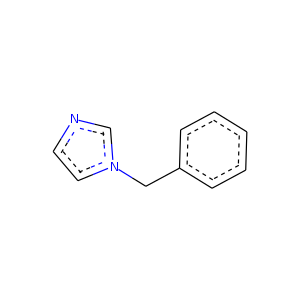
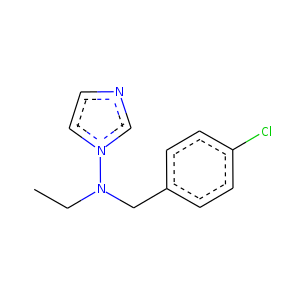
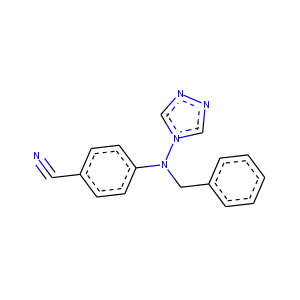
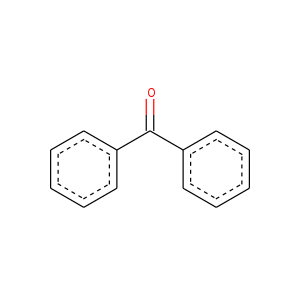
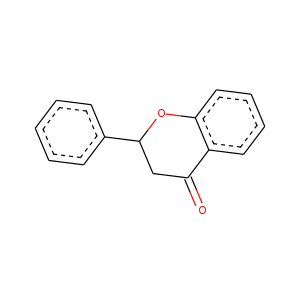

In [72]:
tbl = []
for row in alldata:
    for r in row:
        tid,docid,ref,tpl,_ = r
        m = Chem.MolFromSmarts(tpl.smarts)
        m.UpdatePropertyCache(False)
        #svg = moltosvg(m,kekulize=False)
        tbl.append((tid,tpl.numAtoms,tpl.avgNumMolAtoms.mean(),m,tpl.smarts,tpl.mcsTime))
df = pd.DataFrame(data=tbl,columns=('tid','numAtoms','avgNumMolAtoms','mol','smarts','time'))
PandasTools.RenderImagesInAllDataFrames(images=True)
df.head(5)

How many "scaffolds" do we have in total?

In [18]:
len(df)

648

How many are reasonably sized?

In [19]:
len(df[df.numAtoms>6])

640

Not bad! It's still worth looking at the ones that are super small:

,tid,numAtoms,avgNumMolAtoms,mol,smarts,time
128,13001,6,33.538462,,"[#6]1:[#6]:[#6]:[#6]:[#6]:[#6,#7]:1",0.010566
188,15,5,11.400000,,"[#6,#7,#8]-[#6,#7,#8]-[#6](-,=[#6,#8])-,=[#6,#8]",0.001489
189,15,6,16.300000,,"[#7,#6,#8,#16]-,=[#6]1:,-[#7,#16]:,-[#7,#6,#8,#16]:,-[#6,#7]:[#16,#6,#7]:,-1",0.008936
200,15,5,23.608696,,"[#6,#7,#8]-,=[#6,#16](=,-[#8,#6])-[#7,#6]-,=[#6]",0.005014
206,15,6,21.000000,,"[#6]1:[#6]:[#6]:[#6]:[#6,#7]:[#6]:1",0.015131
223,10193,6,15.791667,,"[#6]1:,-[#6,#7]:,-[#6,#8]:,-[#6]:,-[#6]:,-[#6,#7]:,-1",0.005510
238,10193,5,11.900000,,"[#7,#6]-[#6](-[#6,#7]-,=[#6,#8])-,=[#6,#7,#8]",0.000738
249,10193,5,11.400000,,"[#6,#7,#8]-[#6,#7,#8]-[#6](-,=[#6,#8])-,=[#6,#8]",0.001440

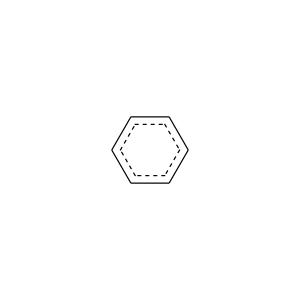
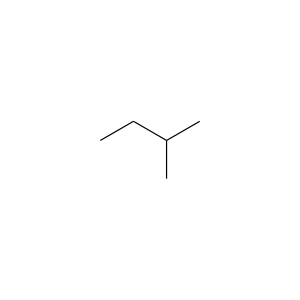
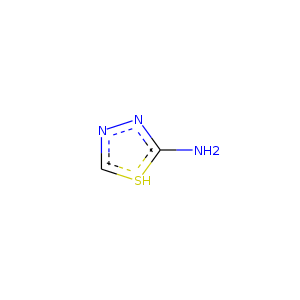
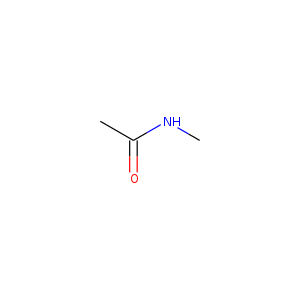
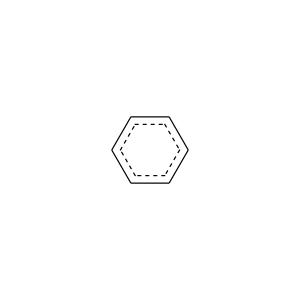
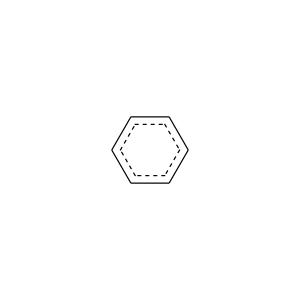
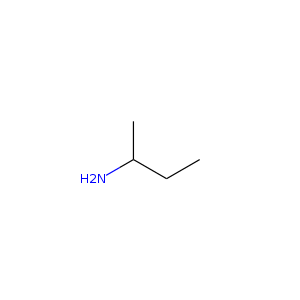
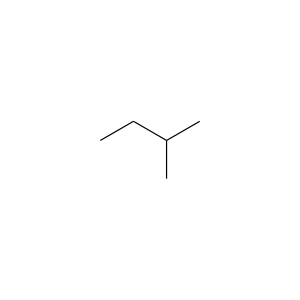

In [20]:
df[df.numAtoms<=6]

We can also render those better:

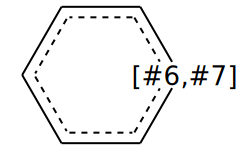

In [68]:
SVG(moltosvg(df[df.numAtoms<=6].iloc[0,3],kekulize=False,molSize=(250,150)))


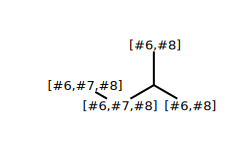

In [69]:
SVG(moltosvg(df[df.numAtoms<=6].iloc[1,3],kekulize=False,molSize=(250,150)))


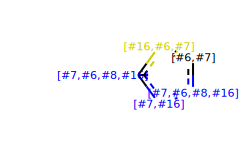

In [70]:
SVG(moltosvg(df[df.numAtoms<=6].iloc[2,3],kekulize=False,molSize=(250,150)))


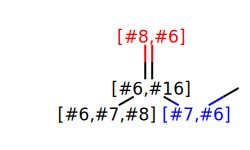

In [71]:
SVG(moltosvg(df[df.numAtoms<=6].iloc[3,3],kekulize=False,molSize=(250,150)))


# Wrapping up

There's a lot more we can do with this set of scaffolds. There are more posts to come...